In [41]:
import findspark
findspark.init() #  Adds `pyspark` to `sys.path` at runtime
import pyspark
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.mllib.tree import RandomForest, RandomForestModel, TreeEnsembleModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
import seaborn as sns

from affirm.model_interpretation.shparkley.spark_shapley import (
    compute_shapley_for_sample,
    ShparkleyModel,
)

# Load Spark Kernel
Using `findspark`, but many other ways exist too. See ([Installing Spark](https://spark.apache.org/downloads.html))

In [3]:
pyspark.__version__

'3.0.1'

In [4]:
! echo $JAVA_HOME

/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home


In [5]:
! echo $SPARK_HOME

/usr/local/spark


Create connection to Spark cluster

In [7]:
sc = pyspark.SparkContext(appName="shparkley_example")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=shparkley_example, master=local[*]) created by __init__ at <ipython-input-6-776131e81607>:1 

In [8]:
sql_context = SQLContext(sc)

## Verify it's started using `jps`


In [9]:
! jps -lvm | grep -i spark

20962 org.apache.spark.deploy.SparkSubmit pyspark-shell -Xmx1g


 `org.apache.spark.deploy.SparkSubmit pyspark-shell` is running -- looks good. 

[Look more at configuration:](https://spark.apache.org/docs/latest/cluster-overview.html)
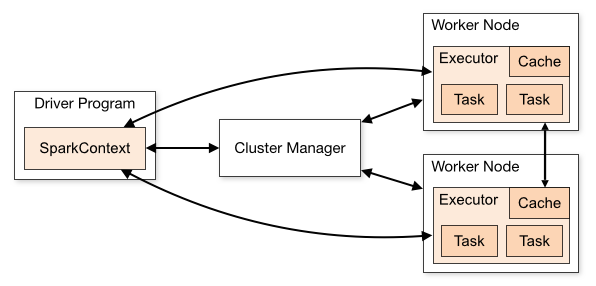

In [10]:
sc.getConf().getAll()

[('spark.app.id', 'local-1603062436205'),
 ('spark.app.name', 'shparkley_example'),
 ('spark.driver.host', '192.168.1.2'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.driver.port', '60779'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [11]:
sc.defaultParallelism, sc.defaultMinPartitions

(8, 2)

This means that by default, `pyspark.DataFrame`s will be created with 8 partitions. 

This is because `sc.parallelize` [here (link)](https://github.com/apache/spark/blob/97605cd1269987ed5ba3013a5f8497375ce8913e/python/pyspark/sql/session.py#L452) is used to convert from local-memory `DataFrame` which uses its `defaultParallelism`. 

There is [no obvious way](https://stackoverflow.com/a/28793407/588437) to get the number of [**executors**](https://spark.apache.org/docs/latest/cluster-overview.html) from the `pyspark` API. 


# Load Sample Dataset

In [12]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [13]:
iris['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

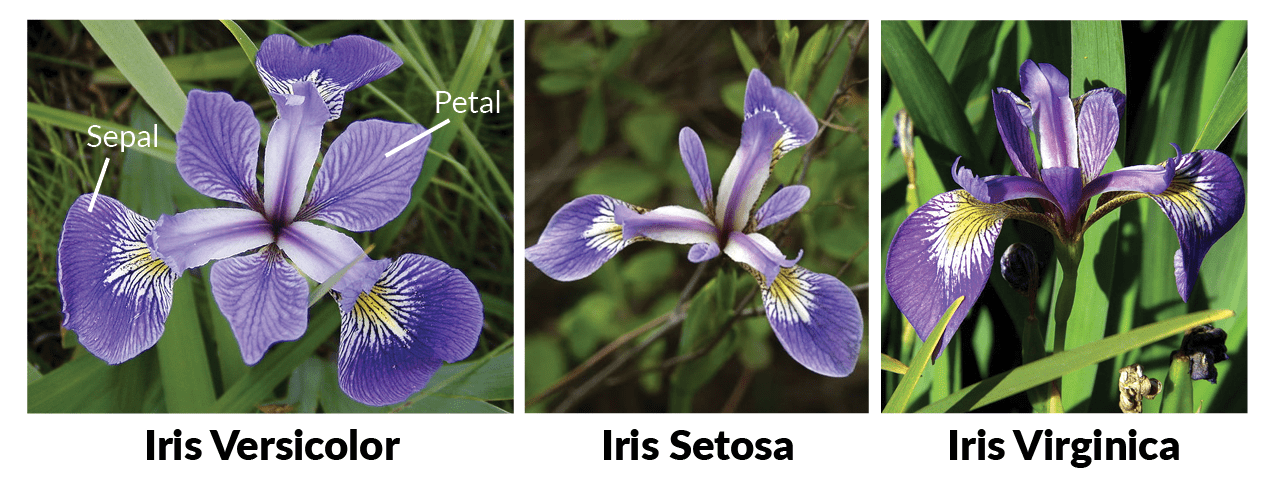 [source](https://www.datacamp.com/community/tutorials/machine-learning-in-r)

## Get rid of Versicolor for simplicity. 

In [14]:
iris_no_vers = iris[
    iris['species'] != 'versicolor'
]    

## Encode output to Setosa: 0, Virginica: 1

In [15]:
iris_no_vers.loc[:, 'species'].replace({'setosa': 0.0, 'virginica': 1.0}, inplace=True)

/Users/ijoseph/opt/miniconda3/envs/3.8/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [16]:
iris_no_vers.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [17]:
spark_iris = sql_context.createDataFrame(iris_no_vers)  # schema is None, so inferring types..
spark_iris

DataFrame[sepal_length: double, sepal_width: double, petal_length: double, petal_width: double, species: double]

Types look reasonable. 

In [18]:
spark_iris.rdd.getNumPartitions()

8

Eight, as foreshadowed. 

In [19]:
spark_iris.show(n=2)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2|    0.0|
|         4.9|        3.0|         1.4|        0.2|    0.0|
+------------+-----------+------------+-----------+-------+
only showing top 2 rows



# Fit Sample Model

Changed into `LabeledPoint`

In [20]:
assembler = VectorAssembler(
    inputCols=[c for c in spark_iris.columns if c != "species"], outputCol="features"
)
spark_iris_transformed = assembler.transform(spark_iris)

In [21]:
spark_iris_transformed = MLUtils.convertVectorColumnsFromML(spark_iris_transformed, "features")

In [22]:
spark_iris_transformed.show(2)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2|    0.0|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|    0.0|[4.9,3.0,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 2 rows



In [23]:
spark_iris_transformed.count()

100

In [24]:
spark_iris_labeled = (spark_iris_transformed.select(col('species'), col('features'))
 .rdd.map(lambda row: LabeledPoint(row.species, row.features))
)

In [25]:
training_data, test_data = spark_iris_labeled.randomSplit([0.7, 0.3])

In [32]:
model = RandomForest.trainClassifier(
    data=training_data,
    numClasses=2,
    numTrees=3,
    categoricalFeaturesInfo={},
    impurity="gini",
    seed=42,
)

In [33]:
predictions = model.predict(test_data.map(lambda x: x.features))

In [34]:
labels_and_predictions = test_data.map(lambda lp: lp.label).zip(predictions)

In [35]:
test_error = labels_and_predictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(test_data.count())
print(f'{test_error=}')
print(model.toDebugString())

test_error=0.0
TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 2 <= 3.3499999999999996)
     Predict: 0.0
    Else (feature 2 > 3.3499999999999996)
     Predict: 1.0
  Tree 1:
    If (feature 3 <= 0.45)
     Predict: 0.0
    Else (feature 3 > 0.45)
     Predict: 1.0
  Tree 2:
    If (feature 3 <= 1.0)
     Predict: 0.0
    Else (feature 3 > 1.0)
     Predict: 1.0



<AxesSubplot:xlabel='petal_length', ylabel='species'>

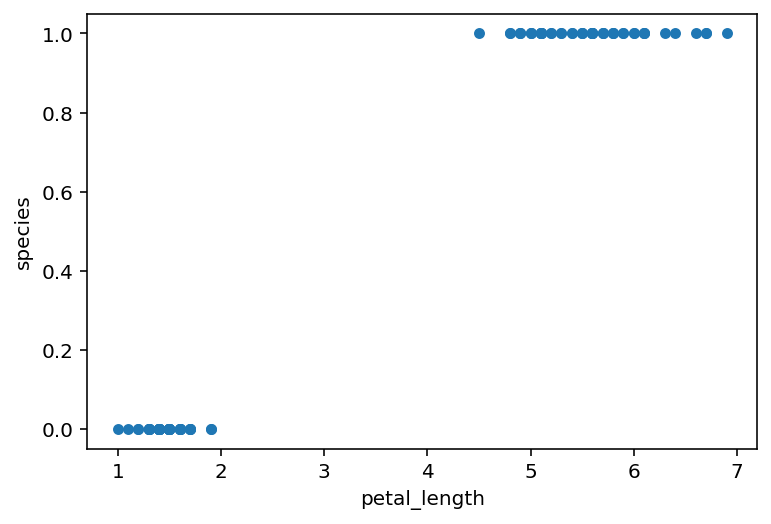

In [37]:
iris_no_vers.plot.scatter(x=iris_no_vers.columns[2], y='species' )

<AxesSubplot:xlabel='petal_width', ylabel='species'>

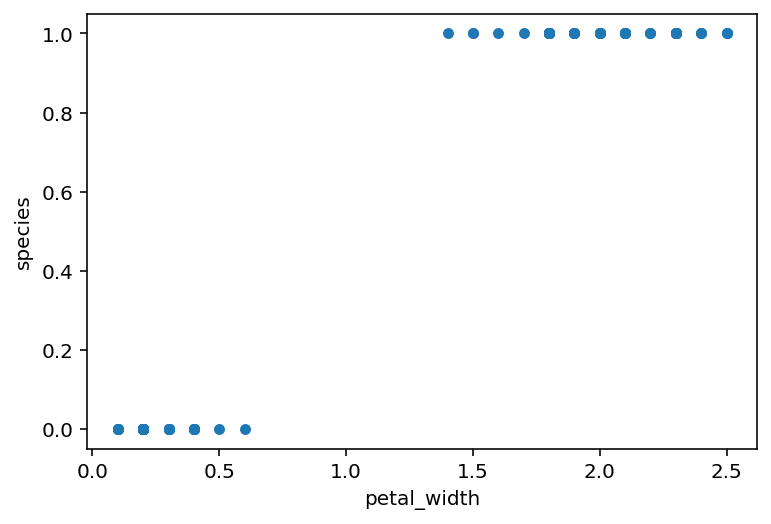

In [36]:
iris_no_vers.plot.scatter(x=iris_no_vers.columns[3], y='species' )

Seems reasonable. Basically a degenerate forest which has trees that can either be an easy petal width or petal length distinction. 

In [39]:
type(model)

pyspark.mllib.tree.RandomForestModel

# Explain with Shapley

In [42]:
class MyShparkleyModel(ShparkleyModel):
    def __init__(self, model: TreeEnsembleModel):
        self._model = model

    def predict(self, feature_matrix: List[Dict[str, Any]]) -> List[float]:
        pd_df = pd.DataFrame.from_dict(feature_matrix)
        preds = self._model.predict(pd_df)
        return(preds)